# Understanding audio data

In [1]:
import os
import scipy.io as sio
from scipy import signal
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

%matplotlib inline

/home/ubuntu/tensorflow/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## 1. Loading audio samples

Sampling rate is the number of samples collected per second. These samples collected are spaced at equal intervals in time. For the above example, the sampling rate below is 16000 that means 16000 sample per second.

In [9]:
sample_rate, samples = sio.wavfile.read('test_samples/yes.wav')
print(f'{sample_rate} samples per second')

16000 samples per second


In [10]:
Audio(samples, rate=sample_rate)

In [25]:
print(type(samples))
print(samples.shape)

<class 'numpy.ndarray'>
(16000,)


## 2. Visualising audio sample amplitude

Audio is represented as waves. Generally, these waves have 2 axes. Time is represented on the x-axis and Amplitude on the y-axis. So at every instant of time t, we have a value for amplitude.

The total time series length = 1.0 sec (N points = 16000) 


Text(0.5,1,'The total length of time series = 1.0 sec, sample_rate = 16000')

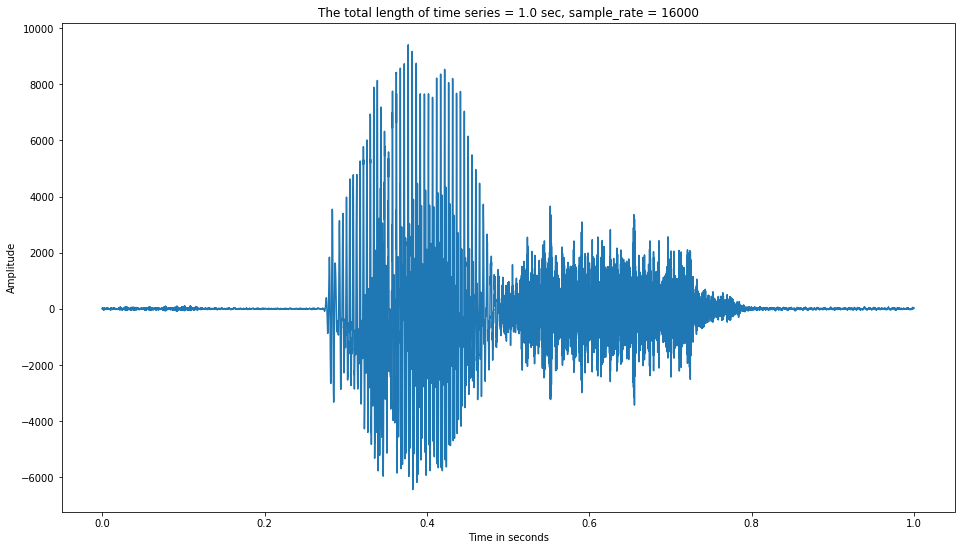

In [23]:
plt.figure(figsize=(16, 9))
audio_duration_in_seconds = len(samples)/sample_rate
print("The total time series length = {} sec (N points = {}) ".format(total_ts_sec, len(samples)))
plt.plot(np.linspace(0, audio_duration_in_seconds, sample_rate), samples)
plt.ylabel('Amplitude')
plt.xlabel('Time in seconds')
plt.title("The total length of time series = {} sec, sample_rate = {}".format(len(samples)/sample_rate, sample_rate))

Sound waves are one-dimensional. At every moment in time, they have a single value based on the height of the wave. To turn this sound wave into numbers, we just record of the height of the wave at equally-spaced points. This is called `sampling`. We are taking a reading thousands of times a second and recording a number representing the height of the sound wave at that point in time. That’s basically all an uncompressed `.wav` audio file is.

Thanks to the [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), we know that we can use math to perfectly reconstruct the original sound wave from the spaced-out samples — as long as we sample at least twice as fast as the highest frequency we want to record.

## 3. Finding spectogram

We can use the above time domain signal as features. But it still requires a lot of computational space because the sampling rate should be quite high. Another way to represent these audio signals is in the frequency domain. We use Fourier transform. Stating in simple terms — Fourier Transform is a tool which allows us to convert our time domain signal into the frequency domain. A signal in the frequency domain requires much less computational space for storage. From [Wikipedia](https://en.wikipedia.org/wiki/Fourier_series):

```
In mathematics, a Fourier series is a way to represent a function as the sum of simple sine waves. More formally, it decomposes any periodic function or periodic signal into the sum of a (possibly infinite) set of simple oscillating functions, namely sines and cosines
```

In simple terms, any audio signal can be represented as the sum of sine and cosine waves.

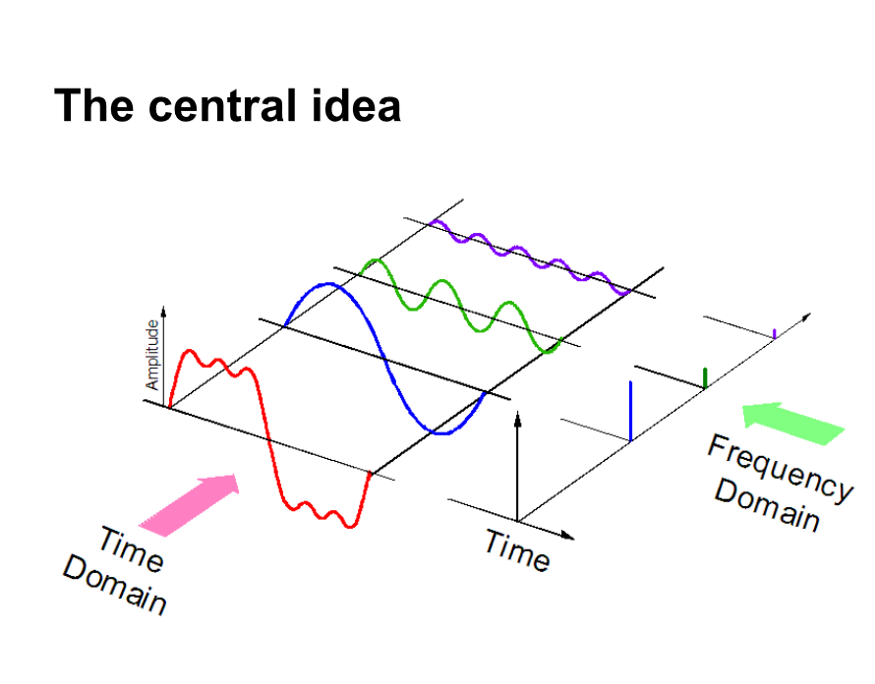

Since the signal is represented as 3 sine waves, we only need 3 values to represent the signal.

In [26]:
# Defining a function that calculates spectrogram
# Window functions: https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows

def log_spectogram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    print(nperseg, noverlap)
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [27]:
freqs, times, spectrogram = log_spectogram(samples, sample_rate)
print(freqs.shape)
print(times.shape)
print(spectrogram.shape)

320 160
(161,)
(99,)
(99, 161)


In [28]:
print(freqs[-10:])
print(times[-10:])
print(spectrogram[:10])

[7550. 7600. 7650. 7700. 7750. 7800. 7850. 7900. 7950. 8000.]
[0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
[[ -6.779413   -5.364346   -1.5105202 ... -10.745202  -12.887871
  -16.586138 ]
 [-10.962162   -7.049268   -1.5710286 ... -11.846865  -13.048841
  -14.15117  ]
 [ -8.910542   -3.9256027  -1.4329746 ... -10.772169  -10.805441
  -11.912539 ]
 ...
 [ -6.451243   -4.600672   -3.2970386 ... -11.85246   -10.896776
  -11.550241 ]
 [ -7.4787803  -3.9552643  -1.3032724 ... -11.641072  -11.769597
  -12.194225 ]
 [ -9.144521   -3.1436036  -1.7455618 ... -11.554607  -11.559092
  -12.226439 ]]


A window of 20ms takes 320 `nperseg = int(round(window_size * sample_rate / 1e3))` samples from total of 16000 samples in 1 second audio clip. The number of overlapping/repeated samples from the previous window are `noverlap = int(round(step_size * sample_rate / 1e3)) + 1 = 161` samples (This is window function specific). 

Therefore, total number of 320 samples with an overlap of 160 samples, in 16000 samples, is `16000 / 160 -1 = 99`. Now, `16000 / 320 = 50` which gives us the bucket size in which we can group 16000 frequencies from our 16 kHz audio sample and after 160 samples we cover 0.01% of the total number of samples (viz. 16000).

## 4. Plotting the spectogram

If we repeat this process on every 20 millisecond chunk of audio, we end up with a spectrogram (each column from left-to-right is one 20ms chunk)

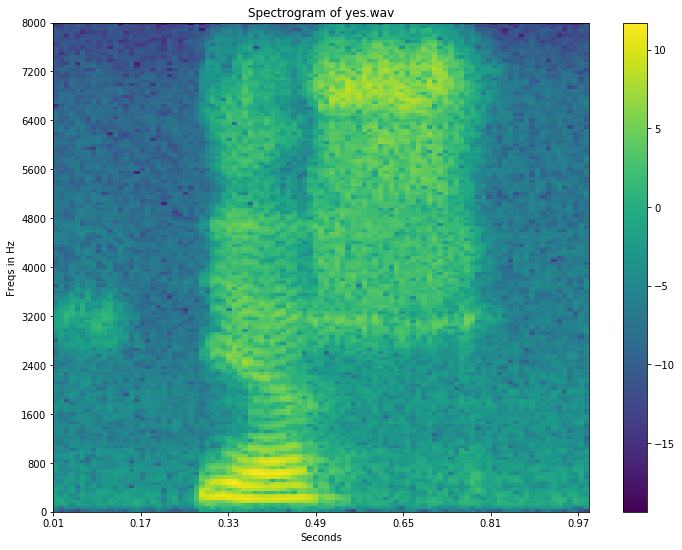

In [42]:
plt.figure(figsize=(12, 9))
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.title('Spectrogram of yes.wav')
plt.ylabel('Freqs in Hz')
plt.xlabel('Seconds')
plt.colorbar(use_gridspec=True)

A spectrogram is cool because you can actually see musical notes and other pitch patterns in audio data. A neural network can find patterns in this kind of data more easily than raw sound waves. So this is the data representation we’ll actually feed into our neural network.

## 5. Mel Power Spectrograms and MFCC

Our voice/sound is dependent on the shape of our vocal tract including tongue, teeth etc. If we can determine this shape accurately, we can recognize the word/character being said. MFCC is a representation of the short-term power spectrum of a sound, which in simple terms represents the shape of the vocal tract. You can read more about MFCCs [here](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

In [43]:
import librosa.display

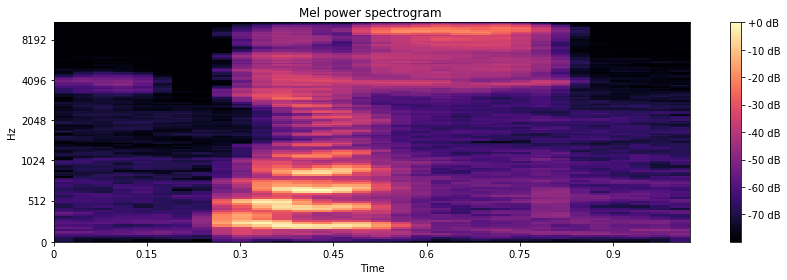

In [44]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples.astype('float32'), sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [45]:
print(log_S.shape)

(128, 32)


Using Librosa to plot raw spectrograms as above

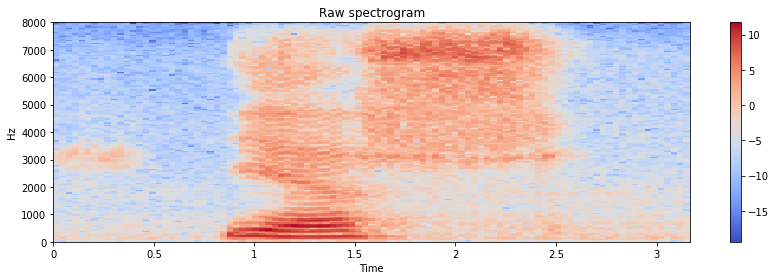

In [46]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(spectrogram.T, sr=sample_rate, x_axis='time', y_axis='linear')
plt.title('Raw spectrogram')
plt.colorbar()
plt.tight_layout()

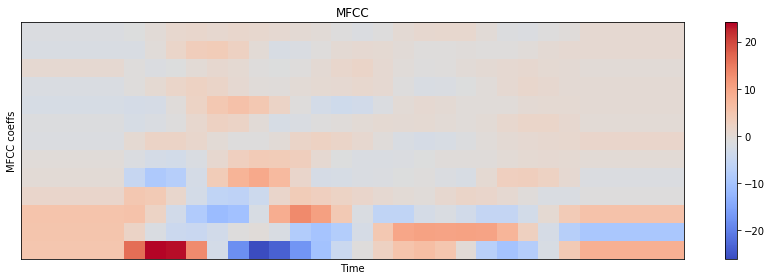

In [47]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In classical, but still state-of-the-art systems, MFCC or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.

It is your decision which to choose!

## Calculating spectogram (from scratch) in Python (OPTIONAL)

To understand what calculations are carried out when we call `log_spectrogram()`, lets calculate the spectogram (from scratch) in Python.

Refer: https://fairyonice.github.io/implement-the-spectrogram-from-scratch-in-python.html

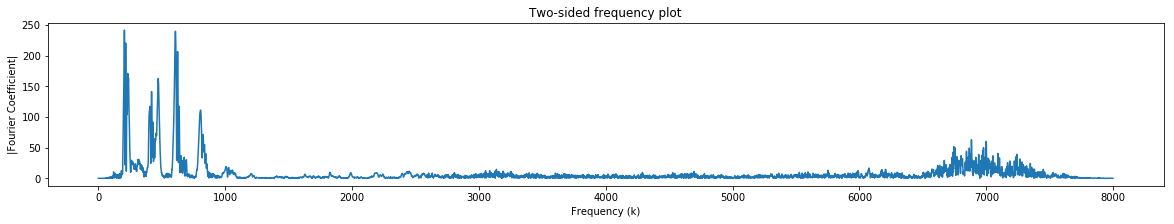

In [37]:
def get_xn(Xs,n):
    '''
    calculate the Fourier coefficient X_n of 
    Discrete Fourier Transform (DFT)
    '''
    L  = len(Xs)
    ks = np.arange(0,L,1)
    xn = np.sum(Xs*np.exp((1j*2*np.pi*ks*n)/L))/L
    return(xn)

def get_xns(ts):
    '''
    Compute Fourier coefficients only up to the Nyquist Limit Xn, n=1,...,L/2
    and multiply the absolute value of the Fourier coefficients by 2, 
    to account for the symetry of the Fourier coefficients above the Nyquist Limit. 
    '''
    mag = []
    L = len(ts)
    for n in range(int(L/2)): # Nyquist Limit
        mag.append(np.abs(get_xn(ts,n))*2)
    return(mag)

mag = get_xns(samples)
# the number of points to label along xaxis
Nxlim = 10

plt.figure(figsize=(20,3))
plt.plot(mag)
plt.xlabel("Frequency (k)")
plt.title("Two-sided frequency plot")
plt.ylabel("|Fourier Coefficient|")
plt.show()

In [38]:
print(len(mag))

8000


Fourier coefficient's frequency (i.e.k in xk) can be translated to frequency in herts as:

$$\frac{\textrm{Sample Rate *} k}{\textrm{Total N of Sample Points} }\;\;\;\; \textrm{(Hz)}$$

Let's create a frequency domain from with xaxis unit in Hz. 

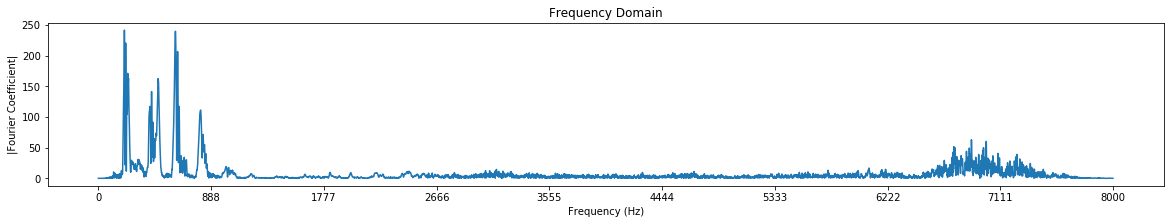

In [39]:
def get_Hz_scale_vec(ks,sample_rate,Npoints):
    freq_Hz = ks*sample_rate/Npoints
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return(freq_Hz)

ks   = np.linspace(0,len(mag),Nxlim)
ksHz = get_Hz_scale_vec(ks,sample_rate,len(samples))

plt.figure(figsize=(20,3))
plt.plot(mag)
plt.xticks(ks,ksHz)
plt.title("Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Fourier Coefficient|")
plt.show()

Since our `sample_rate` is same as `len(samples)` there is no change in our x-axis labels.

In [40]:
def create_spectrogram(ts,NFFT,noverlap = None, eps=1e-10):
    '''
          ts: original time series
        NFFT: The number of data points used in each block for the DFT.
          Fs: the number of points sampled per second, so called sample_rate
    noverlap: The number of points of overlap between blocks. The default value is 128. 
    '''
    if noverlap is None:
        noverlap = NFFT/2
    noverlap = int(noverlap)
    starts  = np.arange(0,len(ts),NFFT-noverlap,dtype=int)
    # remove any window with less than NFFT sample size
    starts  = starts[starts + NFFT < len(ts)]
    xns = []
    for start in starts:
        # short term discrete fourier transform
        ts_window = get_xns(ts[start:start + NFFT]) 
        xns.append(ts_window)
    specX = np.array(xns).T
    # rescale the absolute value of the spectrogram as rescaling is standard
    spec = 10*np.log10(specX + eps)
    assert spec.shape[1] == len(starts) 
    return(starts,spec)

L = 320
noverlap = 160
starts, spec = create_spectrogram(samples,L,noverlap = noverlap)

In [35]:
print(starts.shape)
print(spec.shape)

(98,)
(160, 98)


The above shapes vary slightly mainly due to difference in window functions used while calculating Fourier Transform

Plotting the hand made spectogram

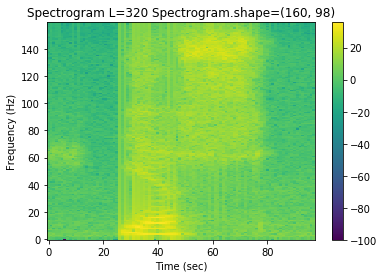

In [36]:
def plot_spectrogram(spec,ks,sample_rate, L, starts, mappable = None):
#     plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(spec, aspect='auto', origin='lower')

    ## create ylim
#     Nyticks = 10
#     ks      = np.linspace(0,spec.shape[0],Nyticks)
#     ksHz    = get_Hz_scale_vec(ks,sample_rate,len(samples))
#     plt.yticks(ks,ksHz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
#     Nxticks = 10
#     ts_spec = np.linspace(0,spec.shape[1],Nxticks)
#     ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,total_ts_sec*starts[-1]/len(samples),Nxticks)]
#     plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Spectrogram L={} Spectrogram.shape={}".format(L,spec.shape))
    plt.colorbar(mappable,use_gridspec=True)
    plt.show()
    return(plt_spec)
plot_spectrogram(spec,ks,sample_rate,L, starts)

###  Wideband spectrogram vs narrowband spectrogram

Refer: [Wideband spectrogram vs narrowband spectrogram](https://fairyonice.github.io/implement-the-spectrogram-from-scratch-in-python.html#Wideband-spectrogram-vs-narrowband-spectrogram)

wideband             time resoulsion=0.01sec, frequency resoulsion=106.67Hz


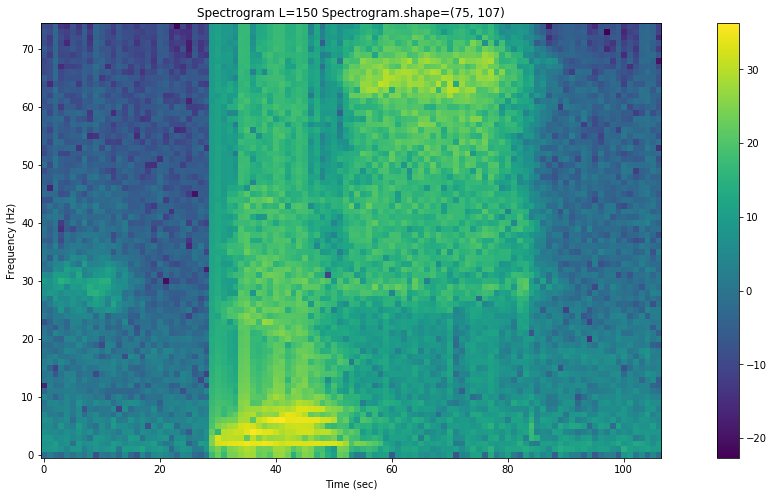

middleband           time resoulsion=0.01sec, frequency resoulsion=80.00Hz


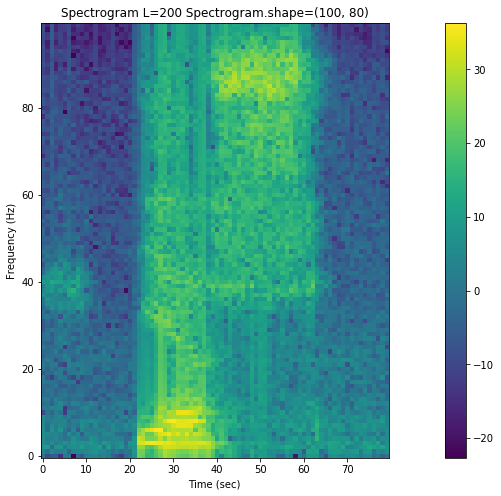

narrowband           time resoulsion=0.03sec, frequency resoulsion=40.00Hz


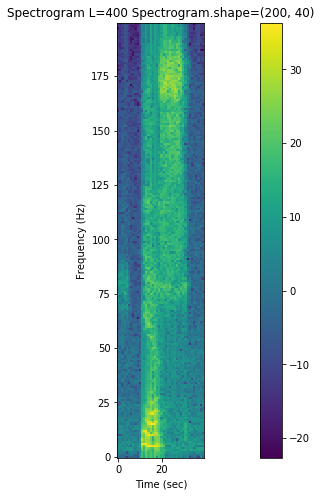

In [92]:
plt_spec1 = None 
for iL, (L, bandnm) in enumerate(zip([150, 200, 400],["wideband","middleband","narrowband"])):
    print("{:20} time resoulsion={:4.2f}sec, frequency resoulsion={:4.2f}Hz".format(bandnm,L/sample_rate,sample_rate/L))
    starts, spec = create_spectrogram(samples,L,noverlap = 1 )
    plt_spec = plot_spectrogram(spec,ks,sample_rate, L, starts, 
                                 mappable = plt_spec1)
    if iL == 0:
        plt_spec1 = plt_spec

Further reading:
* https://www.kaggle.com/davids1992/speech-representation-and-data-exploration